Welcome to your week 2 programming assignment. We will build a neural network, which will have a hidden layer and compare its effectiveness with logistic regression.

The parts of code we expect you to fill have been mentioned or commented.   
Do **NOT** change other parts of the code.

Make sure your directory contains the testCases_v2 and planar_utils files for proper running of the code.

## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [3]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

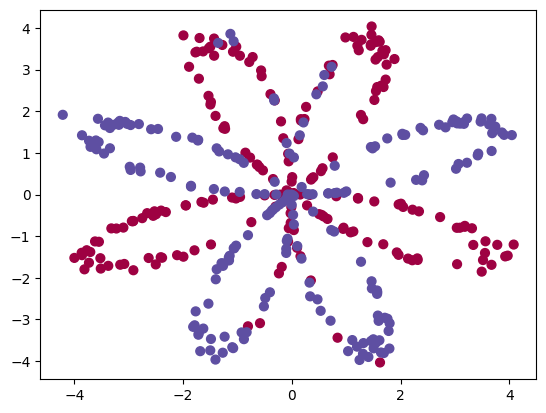

In [4]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like.

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`?

In [6]:
### START CODE HERE ###
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [7]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


You can now plot the decision boundary of these models and calculate its accuracy. Run the code below.

In [36]:
# Plot the decision boundary for logistic regression
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01  # step size

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Use the provided model (which is now the predict function) directly
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)
    plt.title("Decision Boundary for Logistic Regression")
    plt.show()

## 4 - Neural Network model

Logistic regression did **not** work well on the "flower dataset". Let's try training a Neural Network with a single hidden layer.

**Here is our model**:
<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/classification_kiank.png?raw=1" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc).
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Exercise**: Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4)
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [9]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ###
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [10]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values.
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros.
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [13]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(2)

    ### START CODE HERE ###
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [14]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


### 4.3 - The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute Z1, A1, Z2 and A2 (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [15]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ###
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###

    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ###
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###

    assert(A2.shape == (1, X.shape[1]))

    # Values needed in the backpropagation are stored in "cache". This will be given as an input to the backpropagation
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [16]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours.
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

There are many ways to implement the cross-entropy loss.

**Bonus Points** : <u>Try not to use a for loop while calculating the loss</u>


In [18]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2

    Returns:
    cost -- cross-entropy cost given equation (13)

    """

    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ###
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    sum = np.sum(logprobs)
    cost = -sum/m
    ### END CODE HERE ###

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.
                                    # E.g., turns [[17]] into 17
    assert(isinstance(cost, float))

    return cost

In [19]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


Using the cache computed during forward propagation, you can now implement backward propagation.

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/grad_summary.png?raw=1" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [22]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ###
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###

    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ###
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###

    # Backward propagation: calculate dW1, db1, dW2, db2.
    ### START CODE HERE ### (corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.dot(W2.T, dZ2)*(1-np.power(A1,2))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    ### END CODE HERE ###

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [23]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.


In [24]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ###
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###

    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ###
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###

    # Update rule for each parameter
    ### START CODE HERE ###
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [25]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads,1.2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [28]:
# NN_model
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost"
        cost = compute_cost(A2, Y, parameters)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        grads = backward_propagation(parameters, cache, X, Y)

        # Update rule for each parameter
        parameters = update_parameters(parameters, grads,1.2)
        if i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters


In [29]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 1.02,num_iterations=10000)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


### 4.5 Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.


In [32]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ###
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2>0.5,1,0)
    ### END CODE HERE ###

    return predictions

In [33]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219605
Cost after iteration 9000: 0.218598


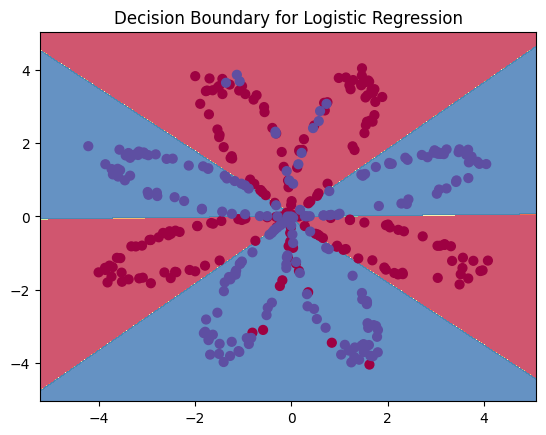

In [38]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, 4, 1.2 , num_iterations = 10000)

# Plot the decision boundary
#CODE HERE
plot_decision_boundary(lambda x: predict(parameters, x.T), X,Y.flatten())

In [39]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


/tmp/ipython-input-39-3101546138.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


Accuracy is really high compared to Logistic Regression. Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression.

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional/ungraded exercise) ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.636621
Cost after iteration 2000: 0.634757
Cost after iteration 3000: 0.633814
Cost after iteration 4000: 0.633205


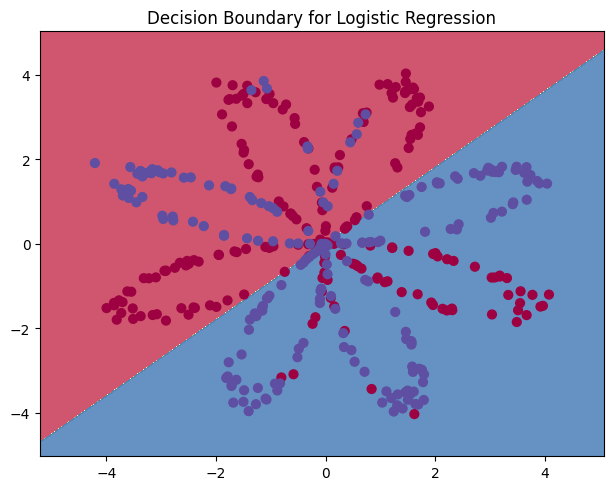

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 1 hidden units: 67.5 %
Cost after iteration 0: 0.693116
Cost after iteration 1000: 0.582325
Cost after iteration 2000: 0.578948
Cost after iteration 3000: 0.577291
Cost after iteration 4000: 0.576190


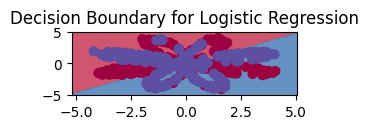

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 2 hidden units: 67.25 %
Cost after iteration 0: 0.693114
Cost after iteration 1000: 0.285502
Cost after iteration 2000: 0.273063
Cost after iteration 3000: 0.266367
Cost after iteration 4000: 0.262067


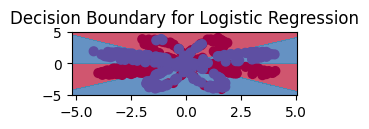

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 3 hidden units: 90.75 %
Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792


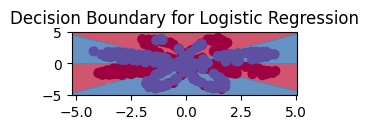

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 4 hidden units: 90.5 %
Cost after iteration 0: 0.693252
Cost after iteration 1000: 0.283771
Cost after iteration 2000: 0.270689
Cost after iteration 3000: 0.263510
Cost after iteration 4000: 0.258455


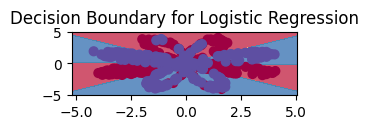

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 5 hidden units: 91.25 %
Cost after iteration 0: 0.693135
Cost after iteration 1000: 0.276658
Cost after iteration 2000: 0.204265
Cost after iteration 3000: 0.182532
Cost after iteration 4000: 0.172728


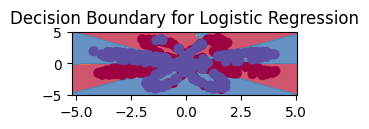

/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 20 hidden units: 90.0 %
Cost after iteration 0: 0.693224
Cost after iteration 1000: 0.278997
Cost after iteration 2000: 0.204375
Cost after iteration 3000: 0.184136
Cost after iteration 4000: 0.181143


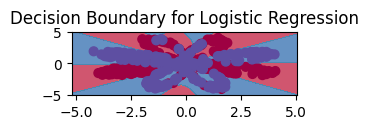

Accuracy for 50 hidden units: 90.25 %


/tmp/ipython-input-40-1293502900.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


In [40]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h,1.2, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Do you notice some trend in the accuracy of the model with respect to number of hidden units? :)